In [1]:
import os
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
import string
from sklearn.calibration import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
from gensim.models import KeyedVectors

2024-10-19 21:46:06.931217: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 21:46:06.938194: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 21:46:06.965921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 21:46:07.024177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 21:46:07.024240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 21:46:07.057065: I tensorflow/core/platform/cpu_feature_guard.cc:

# Punto 1

In [20]:
def clean_gutenberg_text(text):
    text = re.sub(r'^.*?\*\*\* START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*', '', text, flags=re.DOTALL)
    text = re.sub(r'\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*?$', '', text, flags=re.DOTALL)
    authors = r'William Oberfield|James Branch Cabell|Wilhelm Raabe'
    text = re.sub(r'(?i)\b(?:' + authors + r')\b.*?(?=\n)', '', text, flags=re.DOTALL)
    text = re.sub(r'(Produced by.*?Distributed Proofreaders|Title:.*?Author:.*?Release date:.*?Language:.*?Credits:.*?Project Gutenberg Distributed Proofreaders)', '', text, flags=re.DOTALL)
    text = re.sub(r'(CONTENTS.*?THE AFTERWORD|BIBLIOGRAPHY|INDEX)', '', text, flags=re.DOTALL)
    text = re.sub(r'\n+', '\n', text)
    text = text.strip()
    
    return text

In [21]:
def preprocess_text(text):
    text = clean_gutenberg_text(text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer() 
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return tokens

In [22]:
def load_books_from_directory(directory):
    corpus = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    global text
                    text = f.read()
                    tokens = preprocess_text(text)
                    corpus.append(tokens)
    return corpus

In [23]:
directory = 'books' 
corpus = load_books_from_directory(directory)

embedding_sizes = [1200, 2500, 4000]
group_code = "G4"

for size in embedding_sizes:
    model = Word2Vec(sentences=corpus, vector_size=size, window=15, min_count=5, workers=4)
    
    model.save(f'Books_{size}_{group_code}.model')
    print(f"Saved model with size {size} as 'Books_{size}_{group_code}.model'")

print("Training completed.")


Saved model with size 1200 as 'Books_1200_G4.model'
Saved model with size 2500 as 'Books_2500_G4.model'
Saved model with size 4000 as 'Books_4000_G4.model'
Training completed.


#  Punto 2

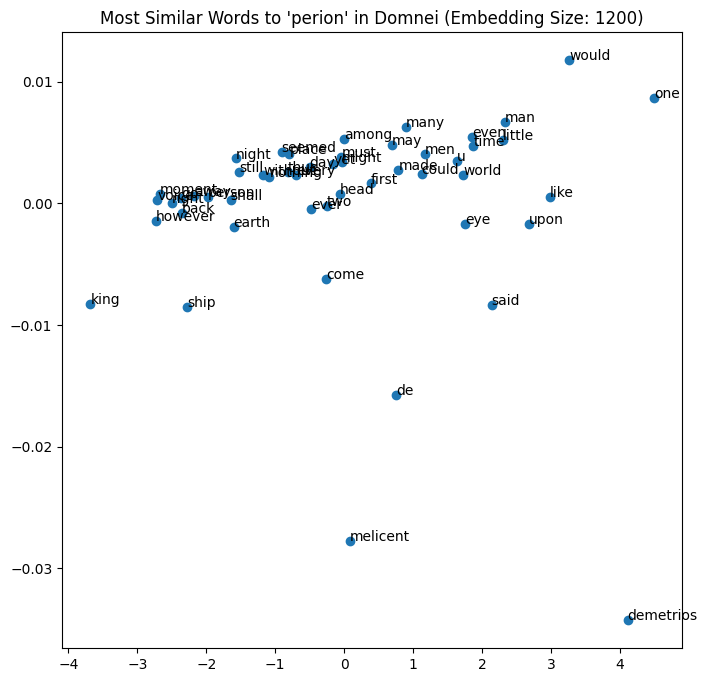

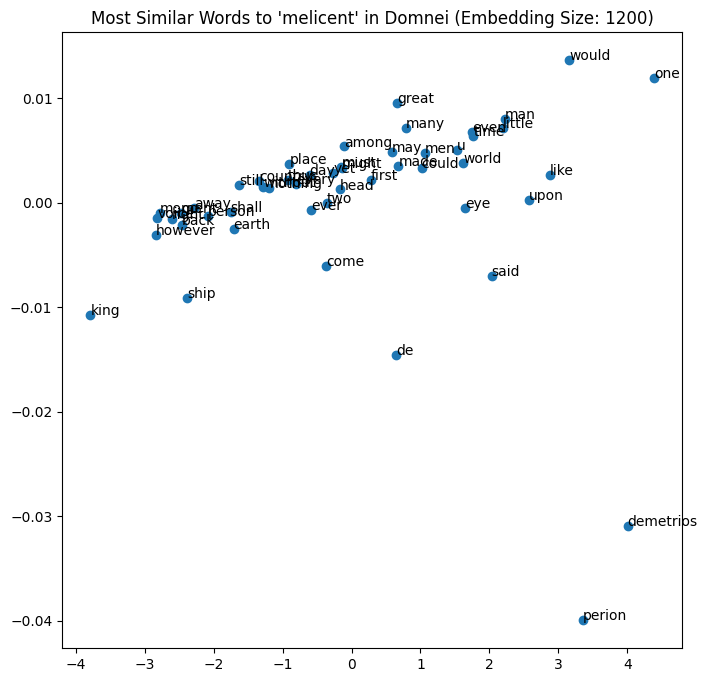

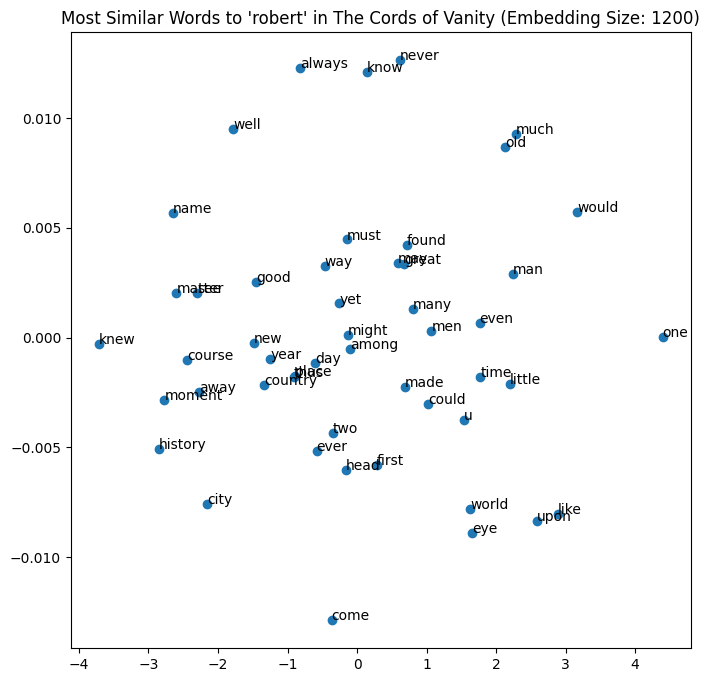

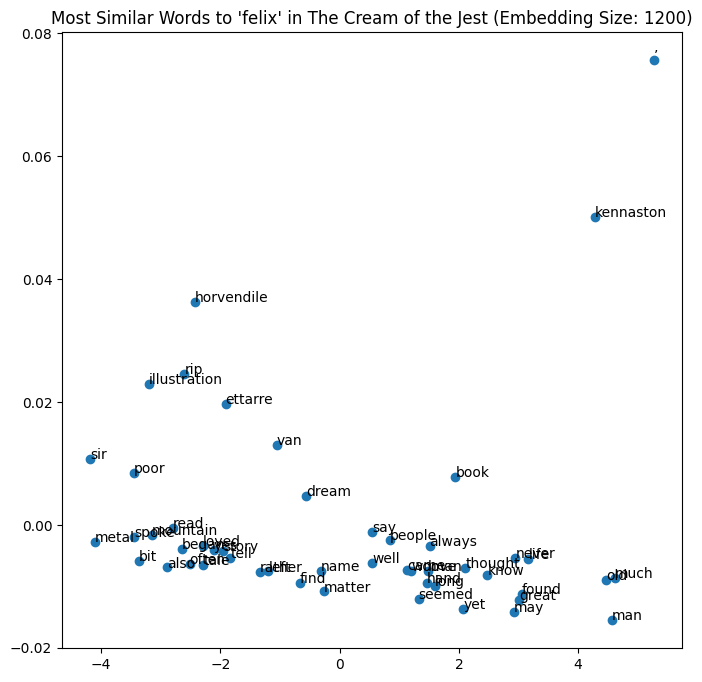

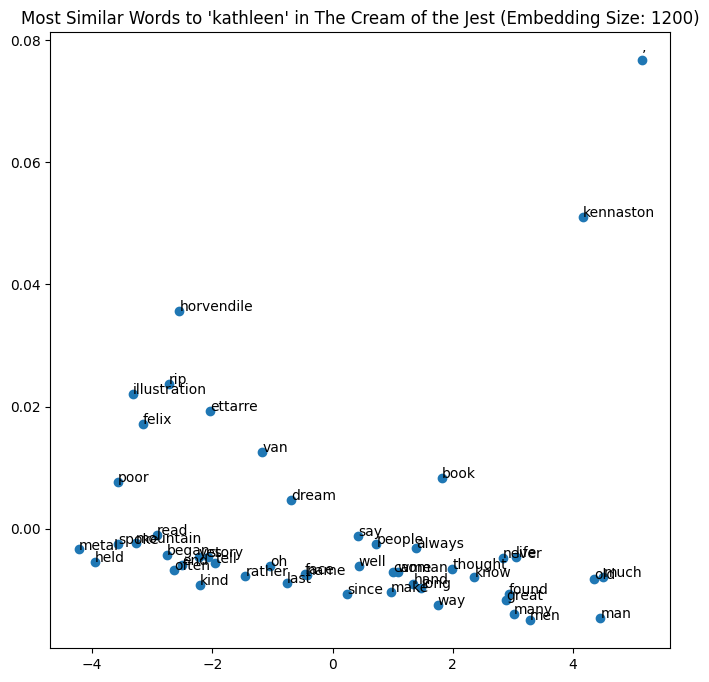

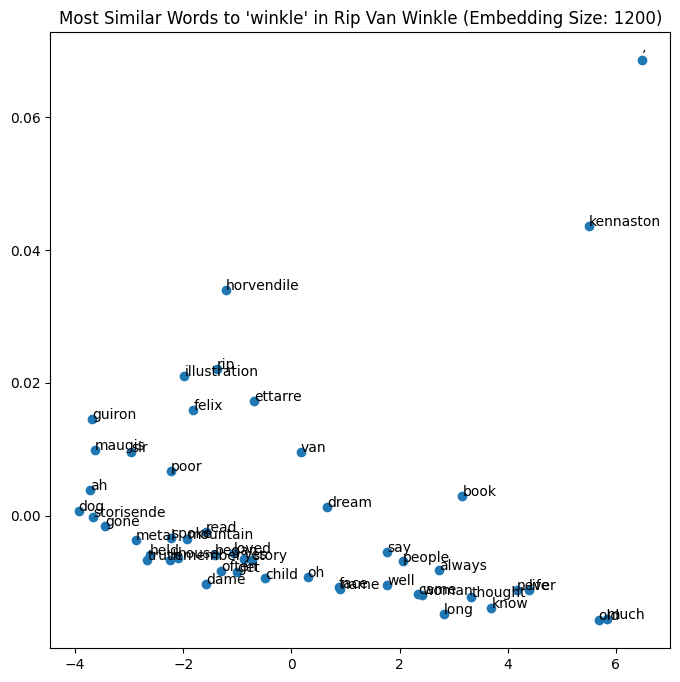

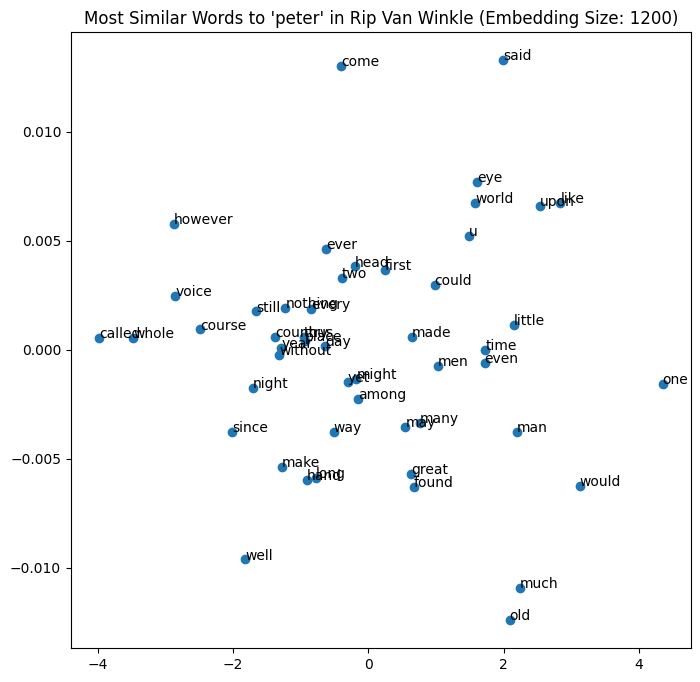

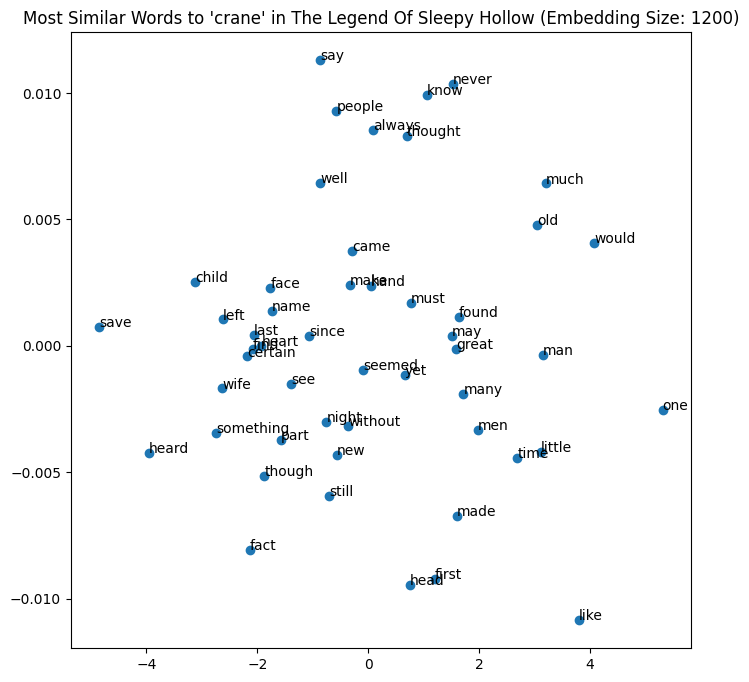

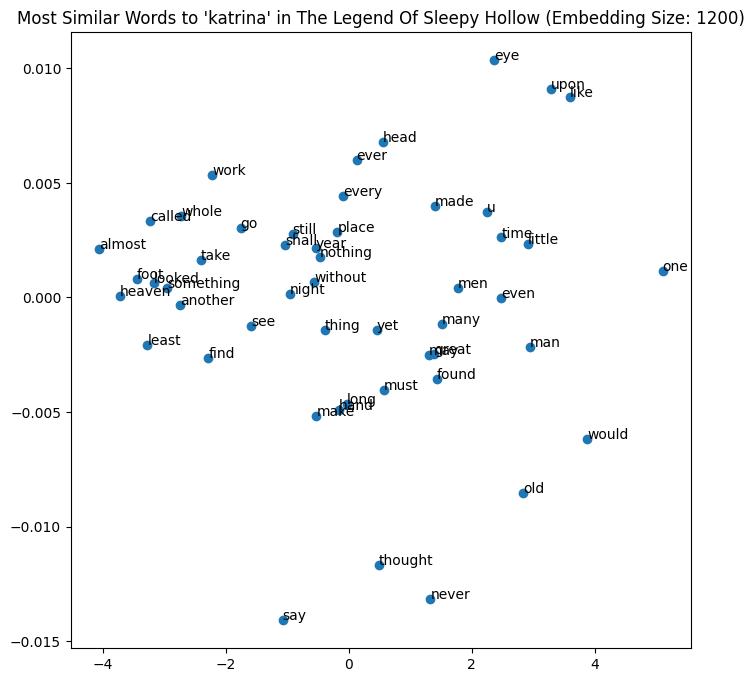

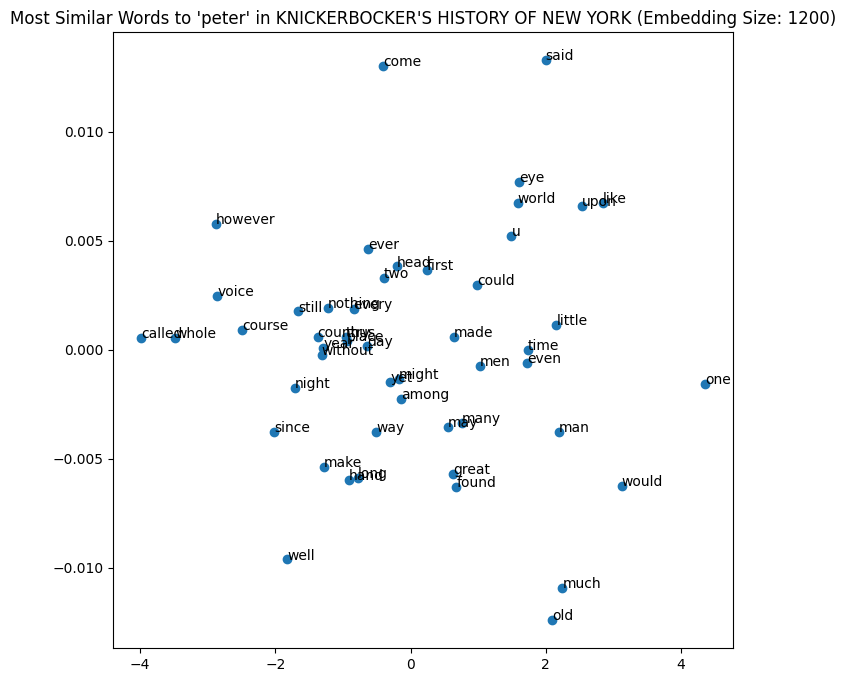

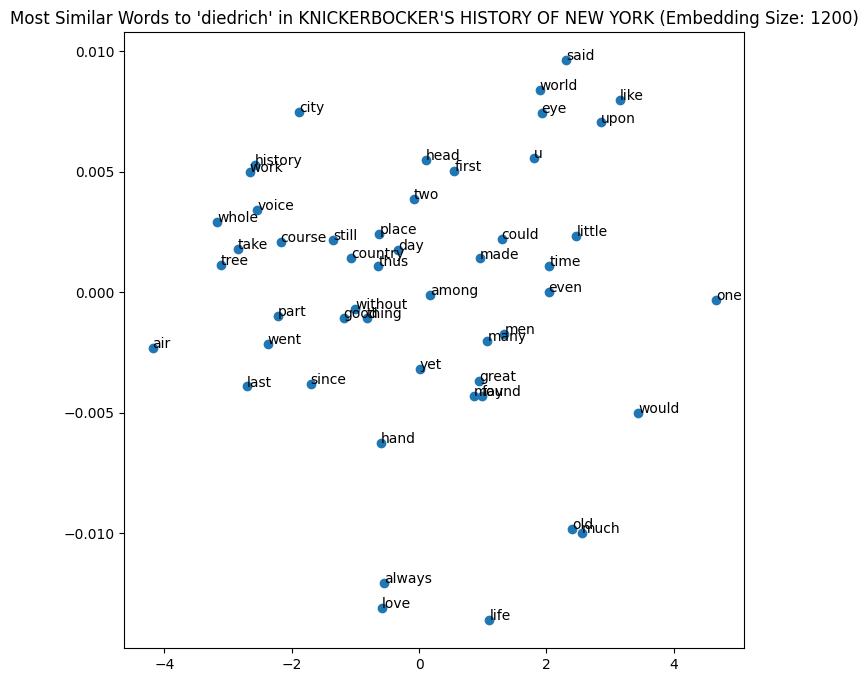

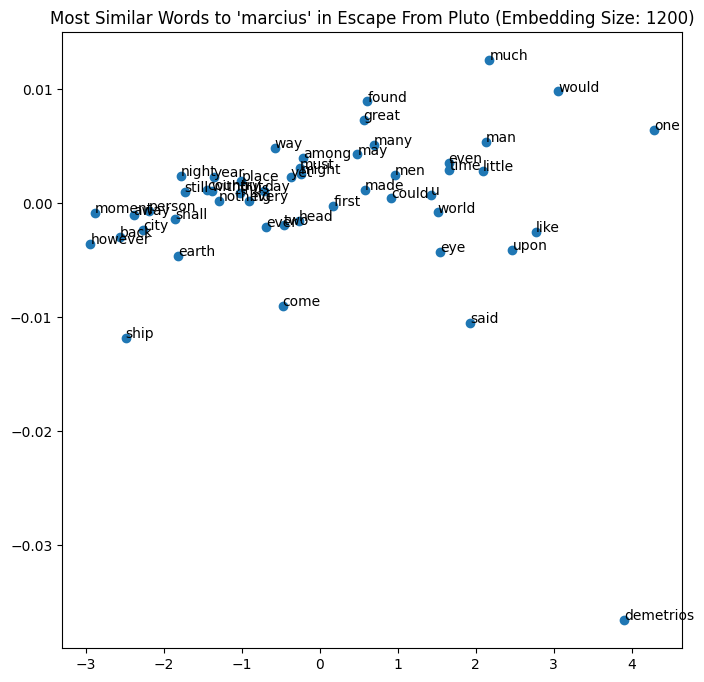

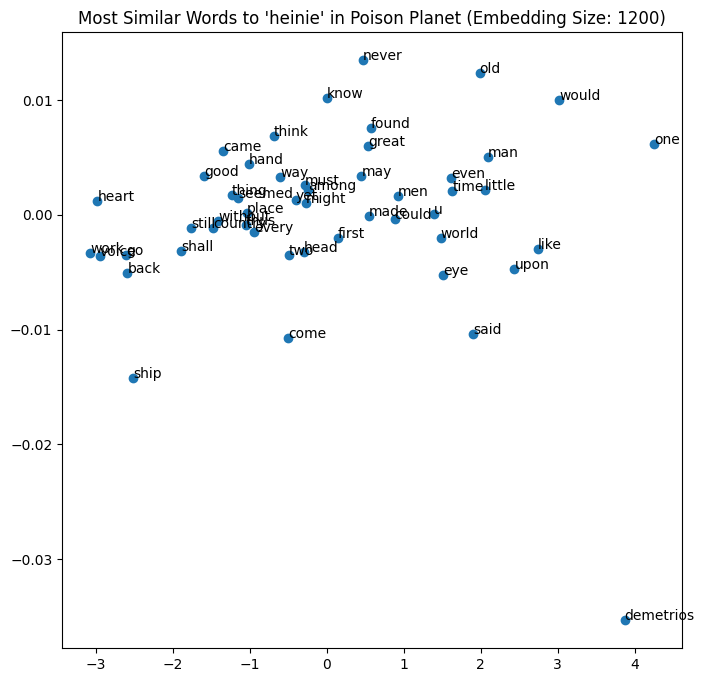

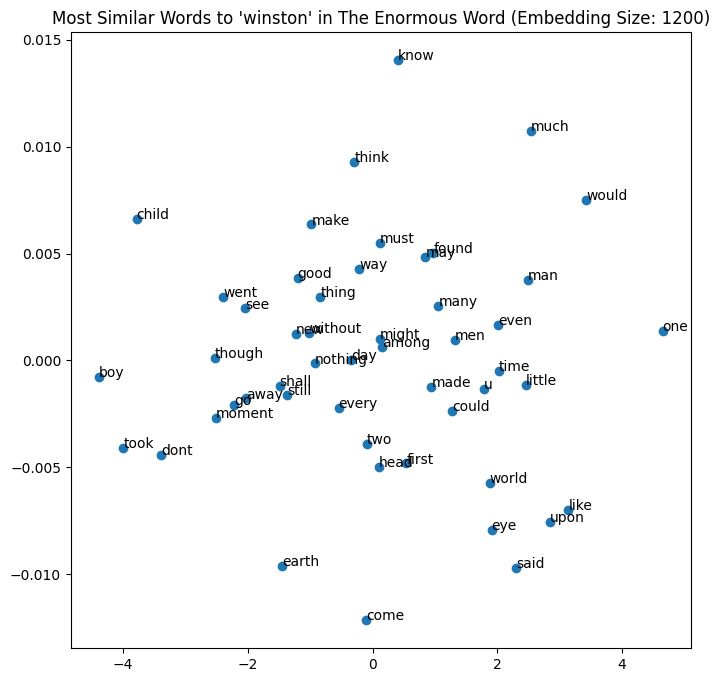

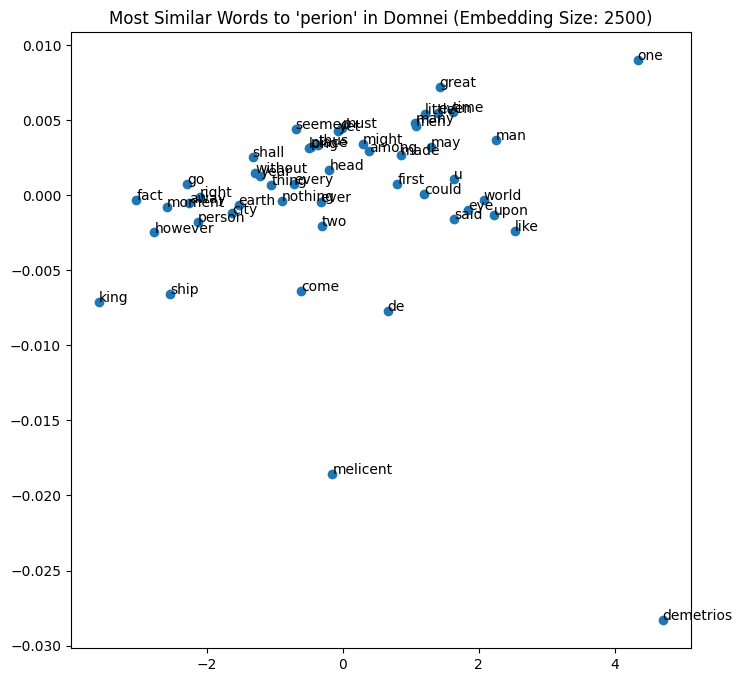

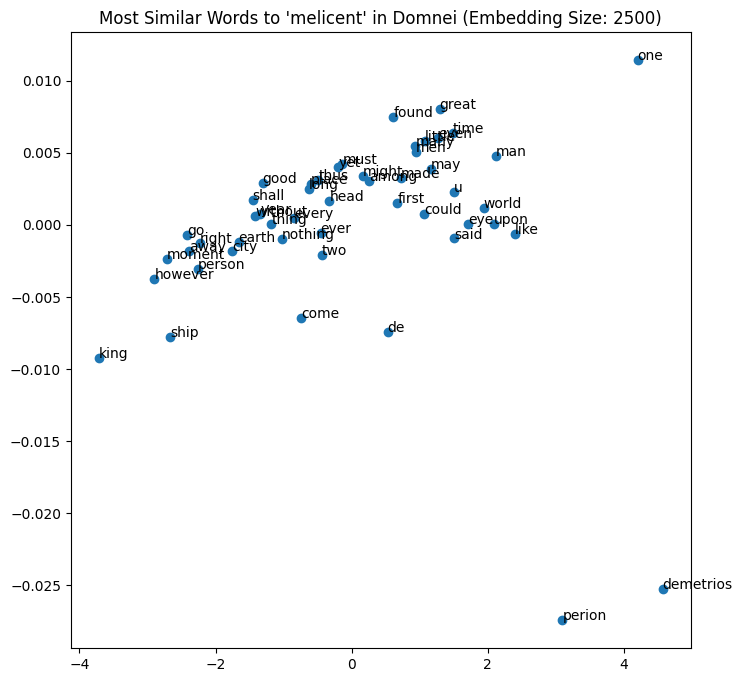

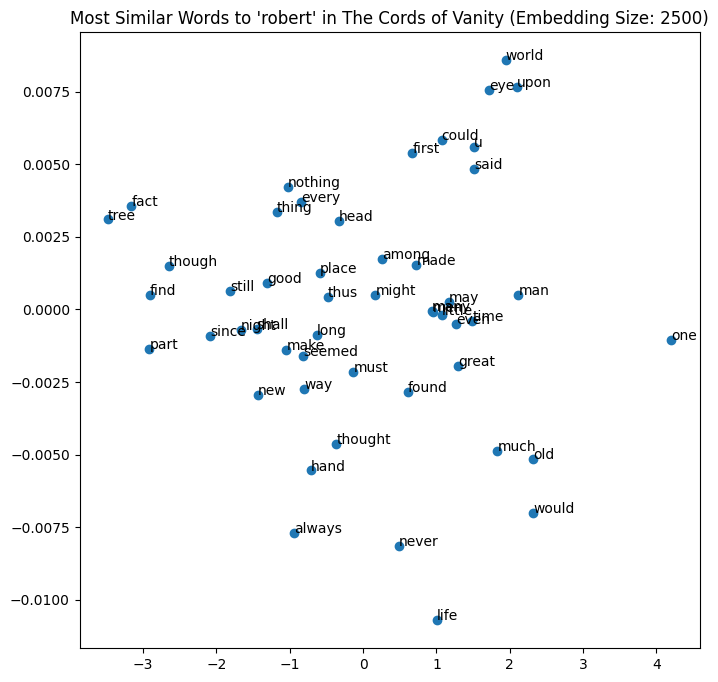

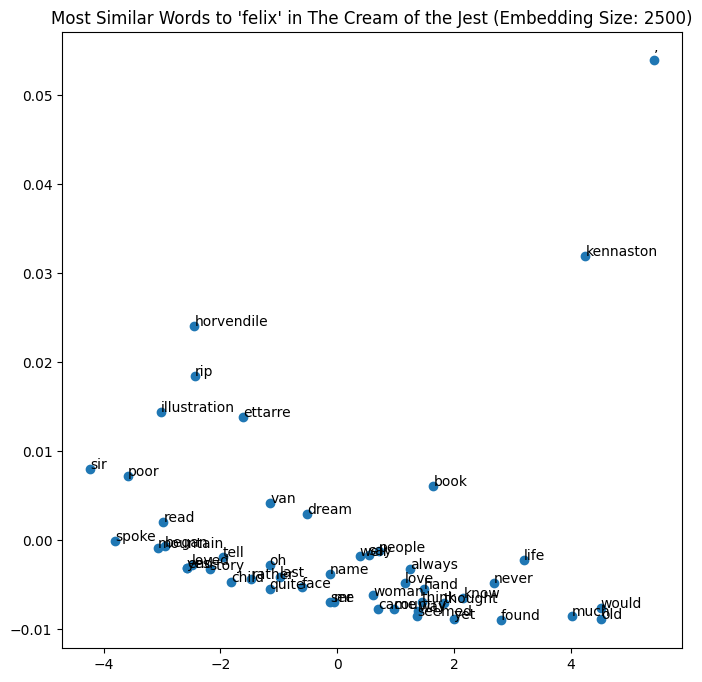

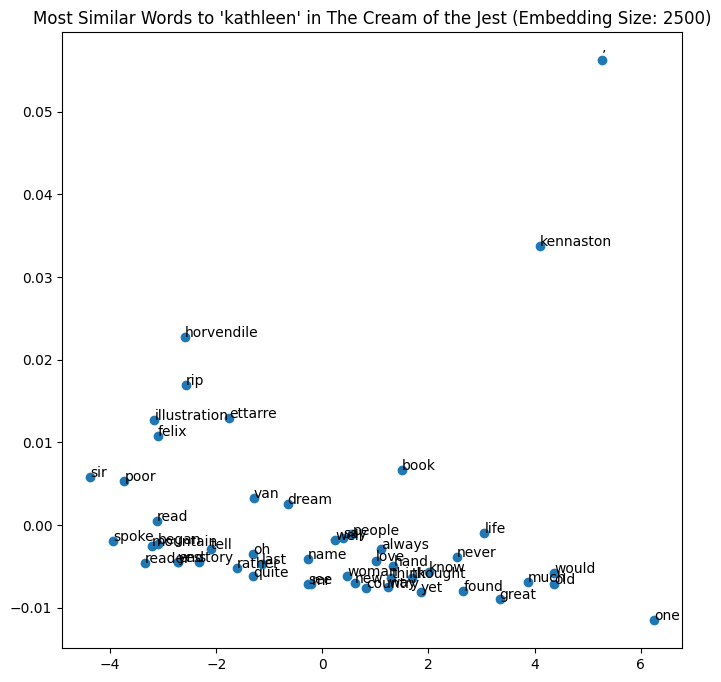

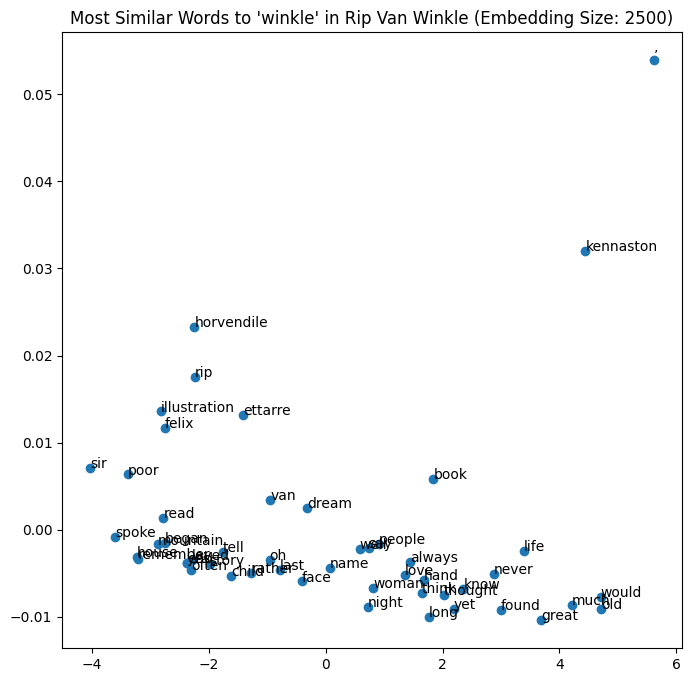

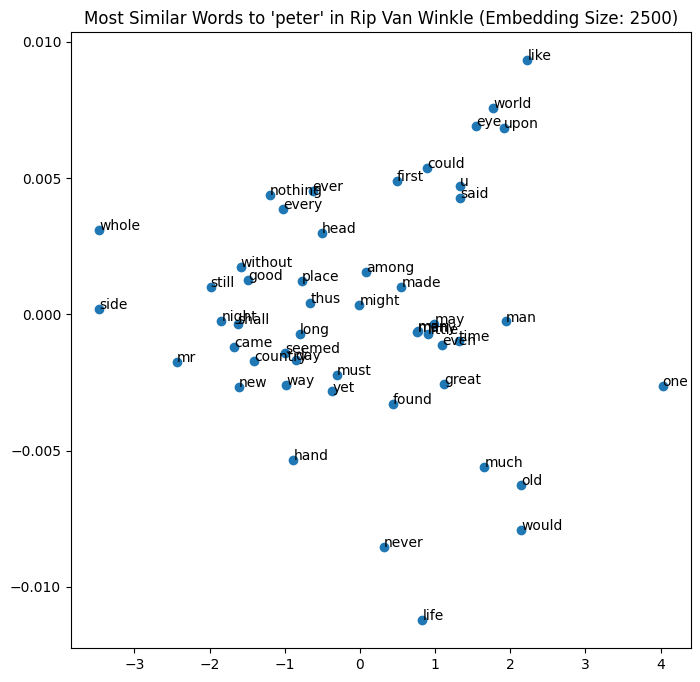

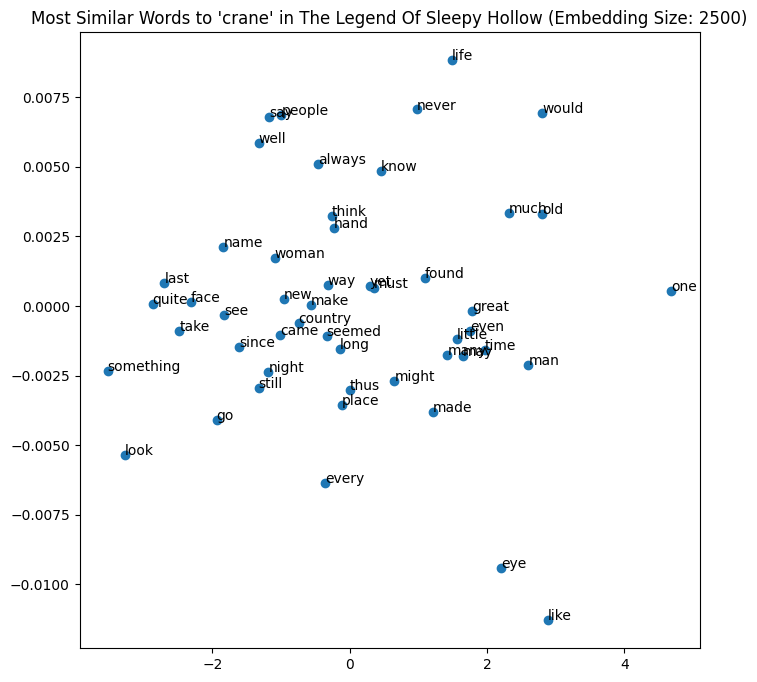

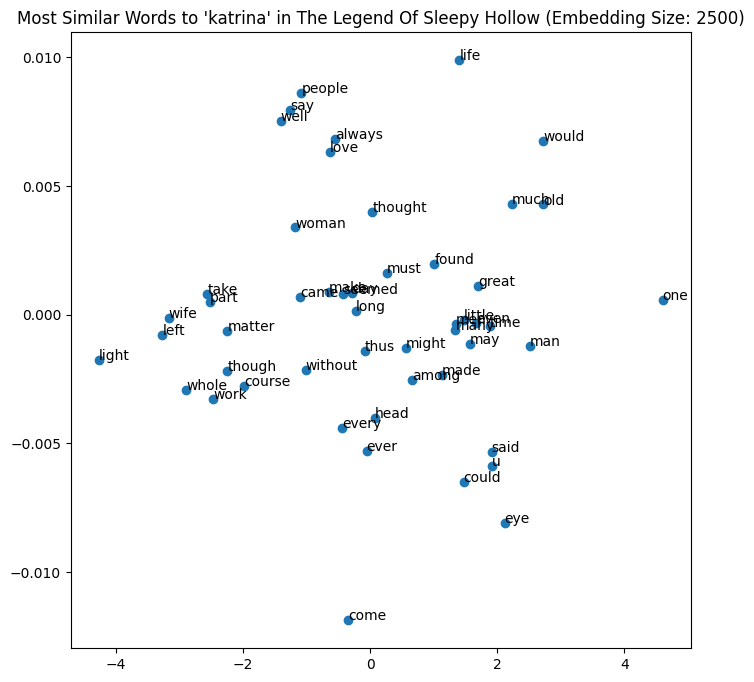

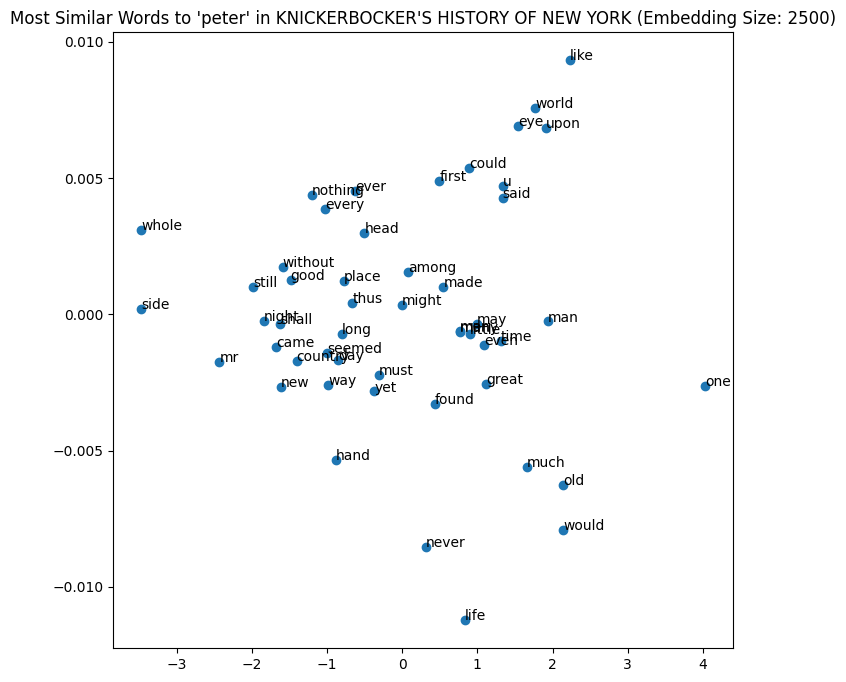

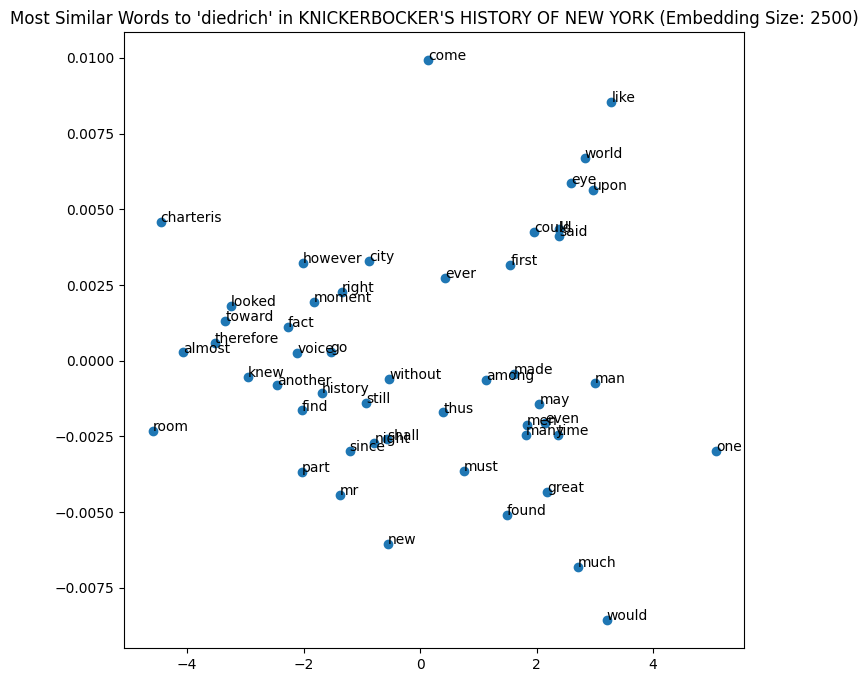

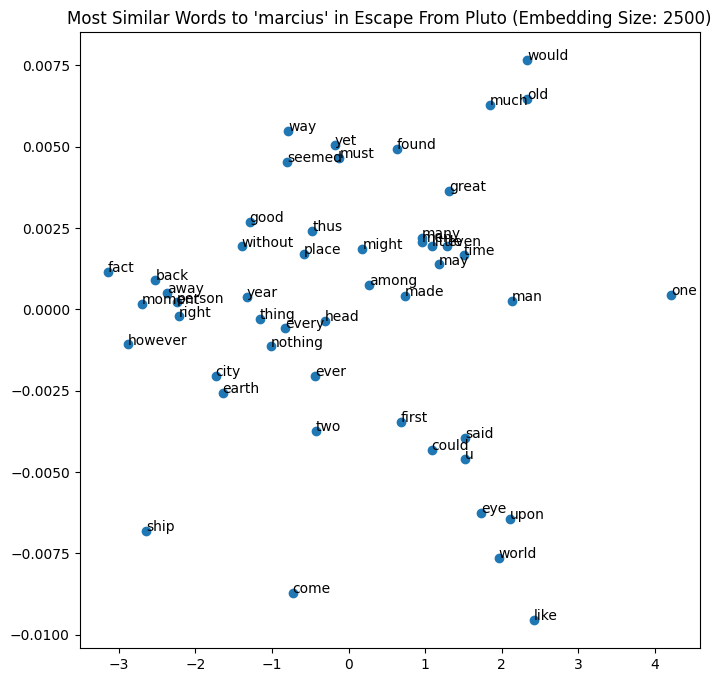

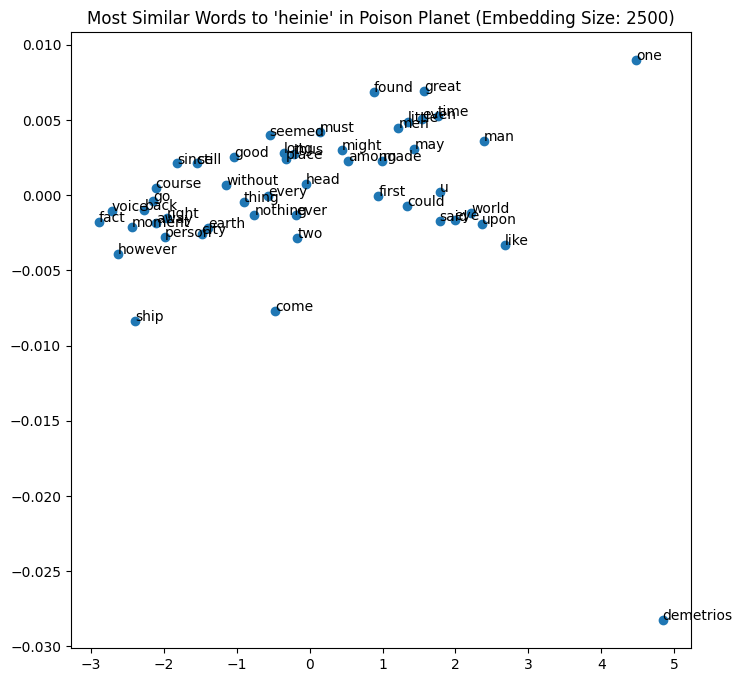

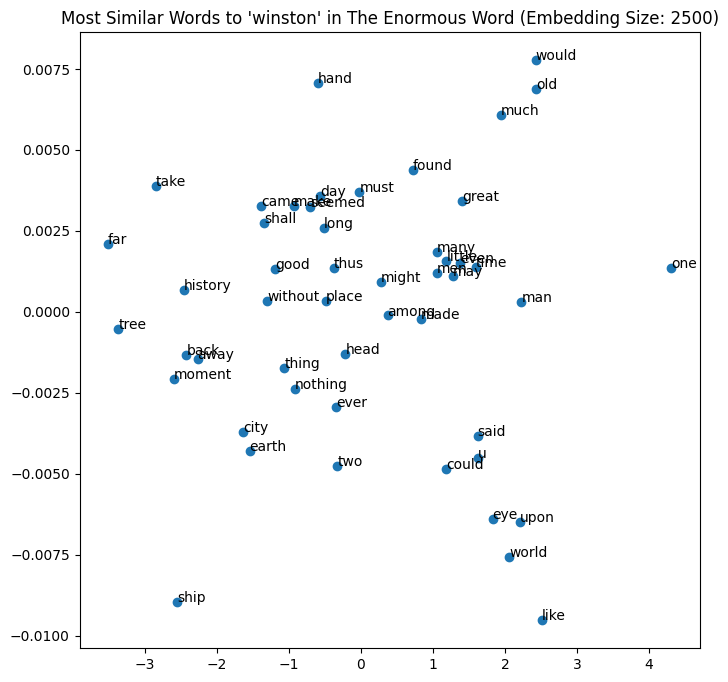

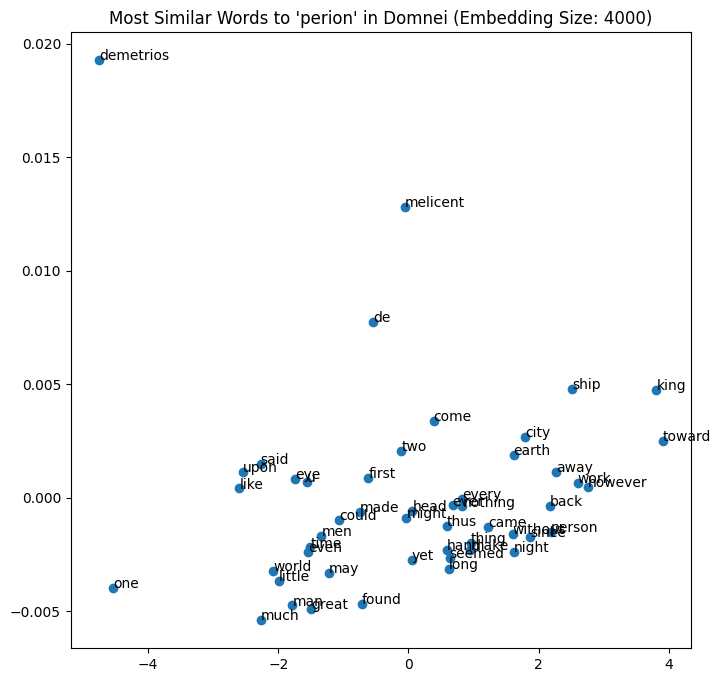

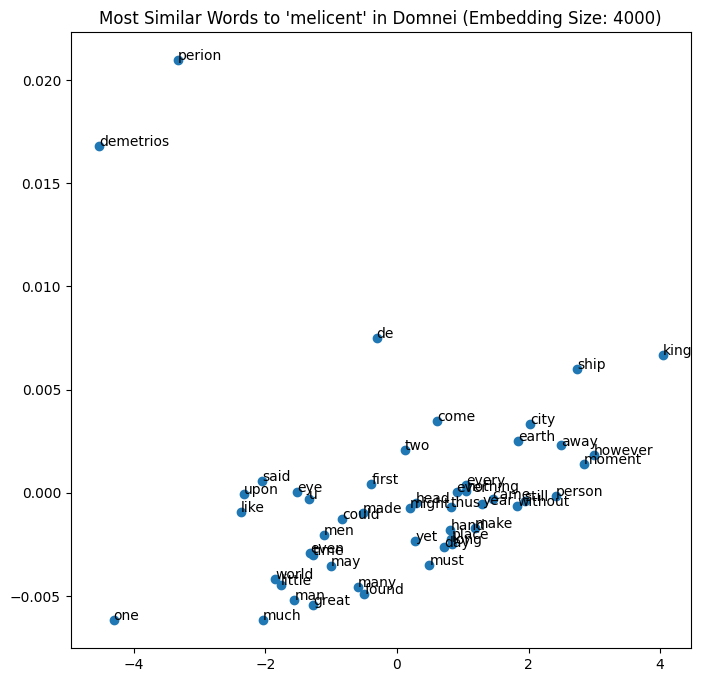

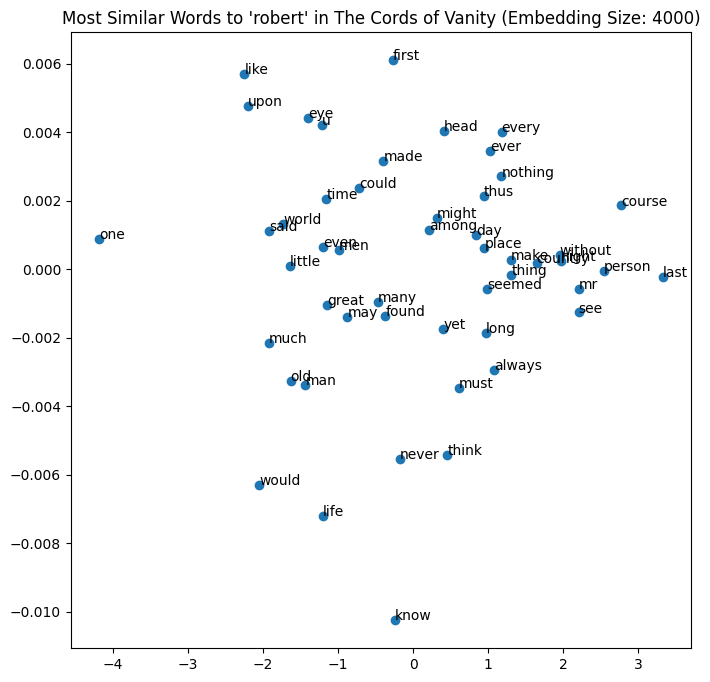

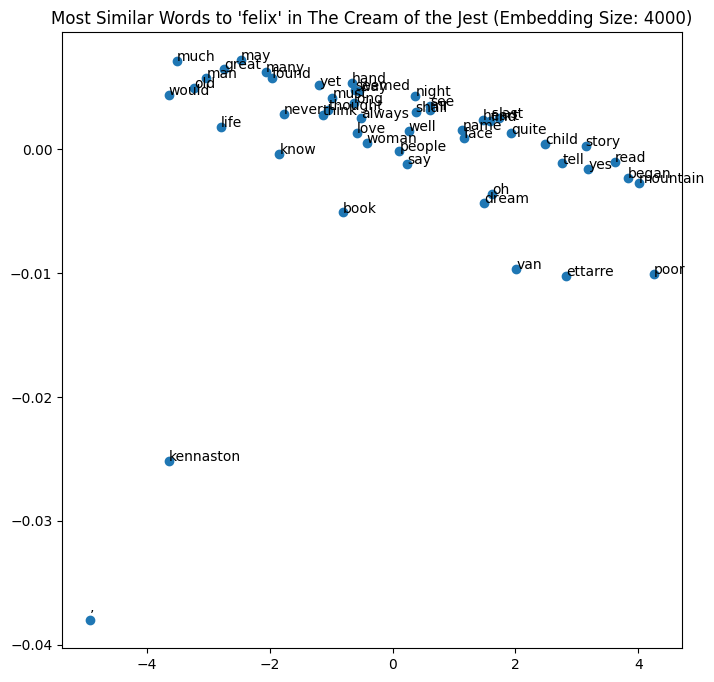

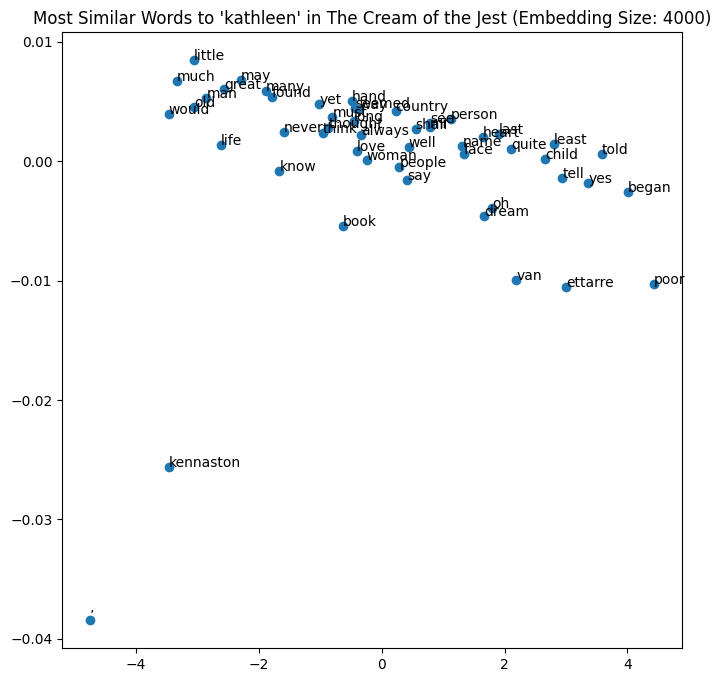

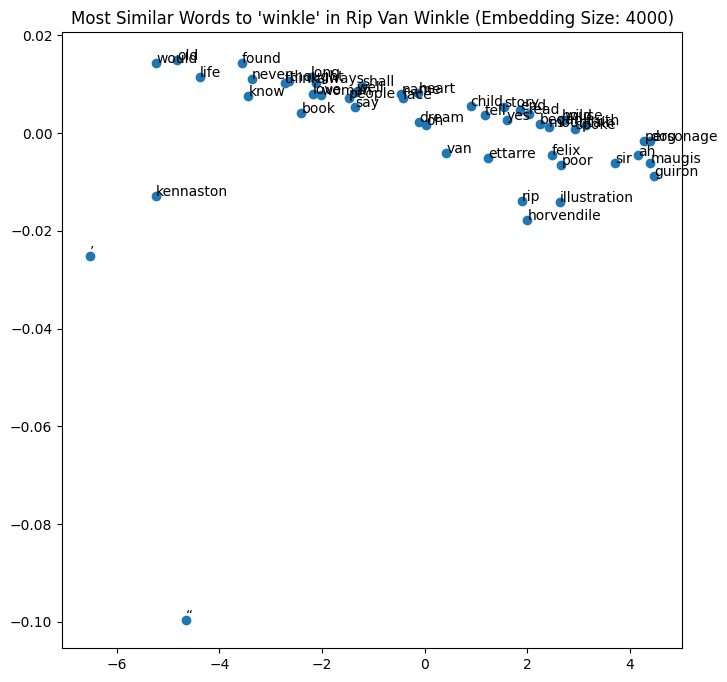

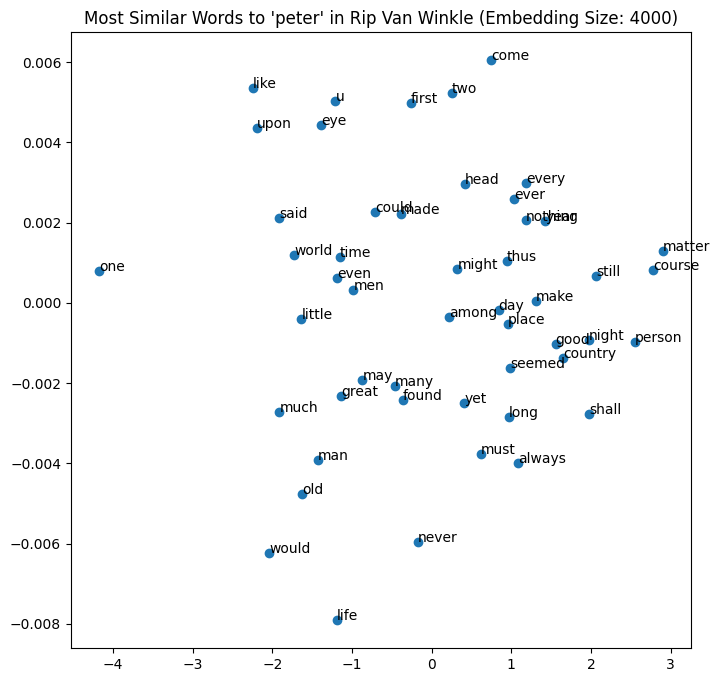

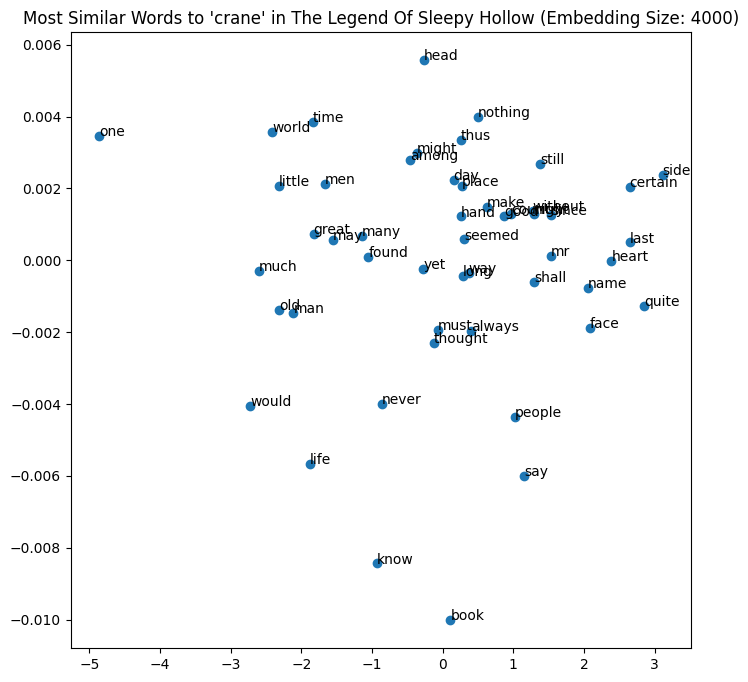

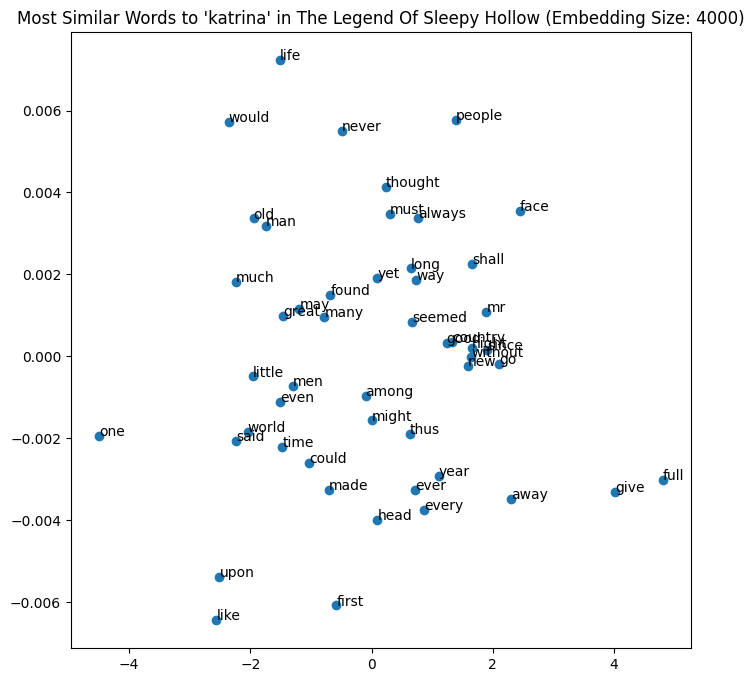

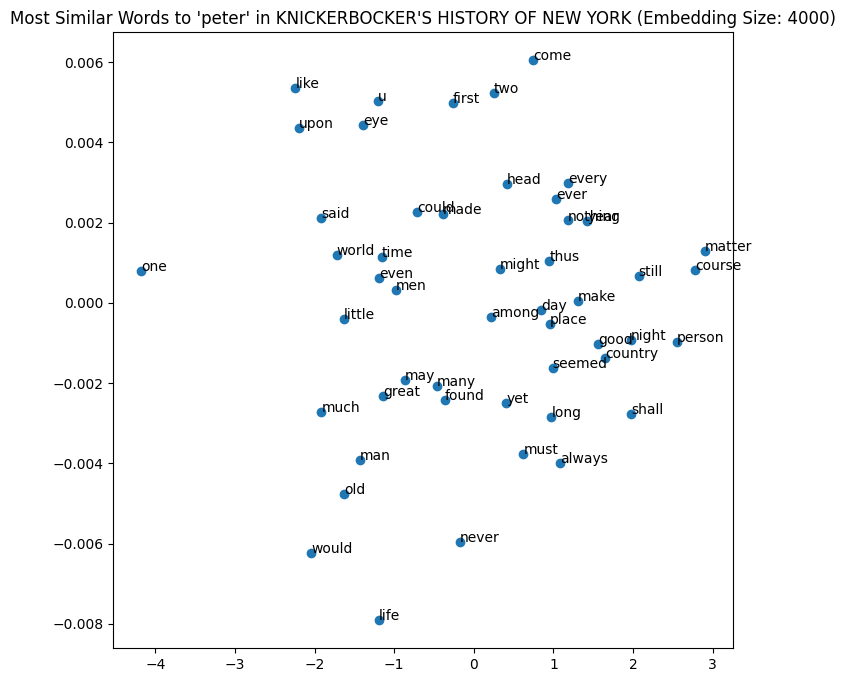

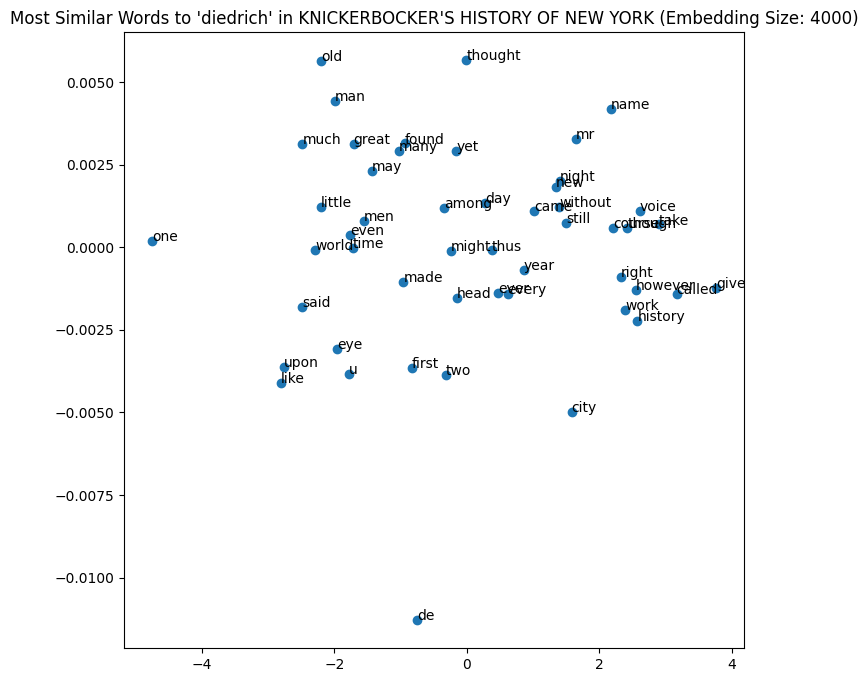

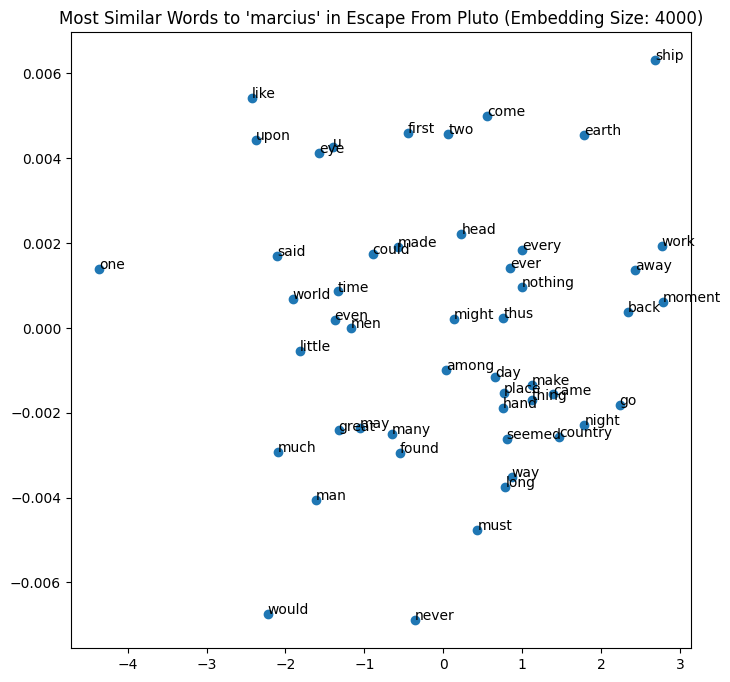

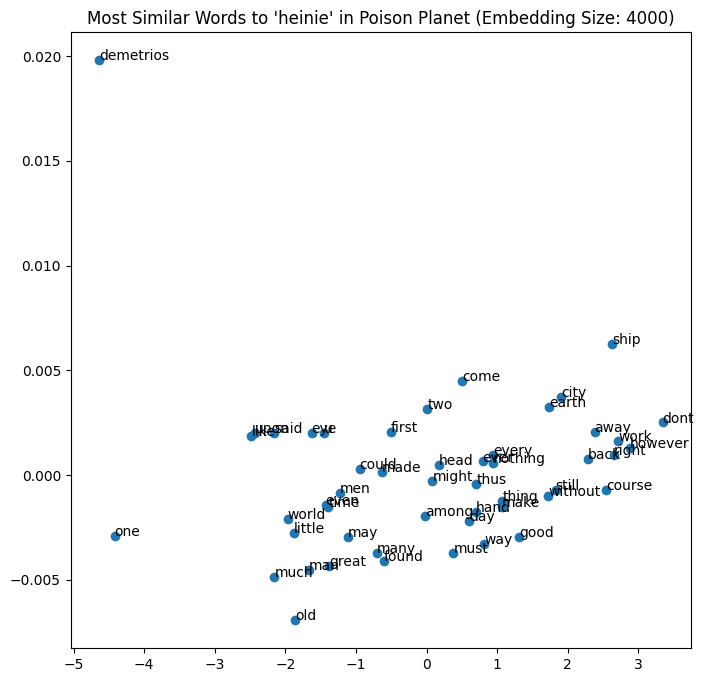

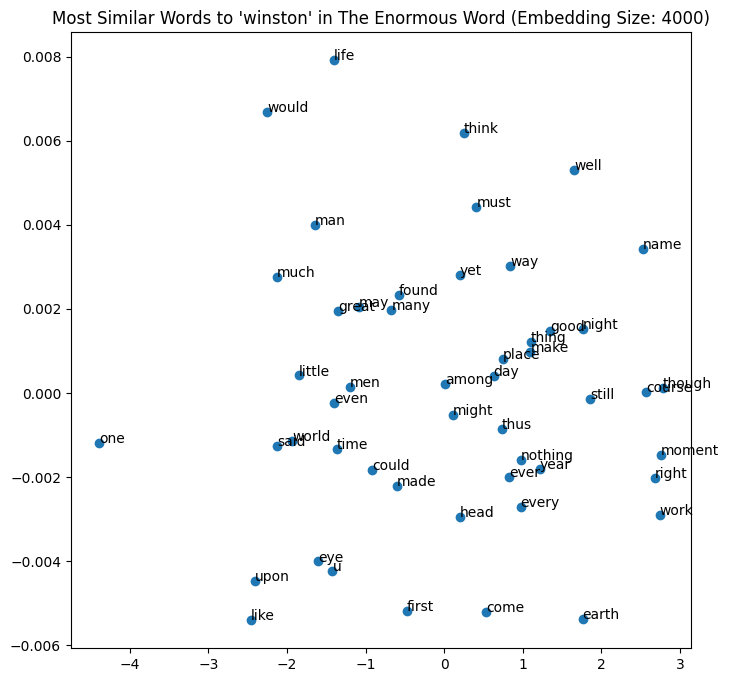

In [28]:
main_characters = {
    "Domnei": ["perion", "melicent"],
    "The Cords of Vanity": ["robert"],
    "The Cream of the Jest": ["felix", "kathleen"],
    "Rip Van Winkle" : ["winkle", "peter"],
    "The Legend Of Sleepy Hollow" : ["crane", "katrina"],
    "KNICKERBOCKER'S HISTORY OF NEW YORK" : ["peter", "diedrich"],
    "Escape From Pluto": ["marcius"],
    "Poison Planet": ["heinie"],
    "The Enormous Word": ["winston"]
}

for size in embedding_sizes:
    model = Word2Vec.load(f'Books_{size}_{group_code}.model')
    
    for book, characters in main_characters.items():
        for char in characters:
            similar_words = model.wv.most_similar(char, topn=50)
            words = [word for word, _ in similar_words]
            word_vectors = np.array([model.wv[word] for word in words])
            pca = PCA(n_components=2)
            reduced_vectors = pca.fit_transform(word_vectors)
            plt.figure(figsize=(8, 8))
            plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])
            for i, word in enumerate(words):
                plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
            plt.title(f"Most Similar Words to '{char}' in {book} (Embedding Size: {size})")
            plt.show()

# Punto 3

In [29]:
def load_embeddings(file_path):
    return KeyedVectors.load(file_path)

embedding_file_paths = {
    1200: 'Books_1200_G4.model',
    2500: 'Books_2500_G4.model',
    4000: 'Books_4000_G4.model', 
}

In [30]:
def split_into_segments(text, segment_size=200):
    words = text.split() 
    segments = [' '.join(words[i:i + segment_size]) for i in range(0, len(words), segment_size)]
    return segments

In [31]:
def load_books_data(base_path='books', segment_size=200):
    texts = []
    labels = []
    authors = os.listdir(base_path)

    for author in authors:
        author_path = os.path.join(base_path, author)
        for book_file in os.listdir(author_path):
            with open(os.path.join(author_path, book_file), 'r', encoding='utf-8') as f:
                book_text = f.read()
                clean_text = clean_gutenberg_text(book_text)
                segments = split_into_segments(clean_text, segment_size)
                texts.extend(segments)
                labels.extend([author] * len(segments))
    
    return texts, labels

In [32]:
embeddings = {size: load_embeddings(path) for size, path in embedding_file_paths.items()}

def create_dataset(texts, authors, embedding_size):
    df = pd.DataFrame({'text': texts, 'author': authors})
    return df

In [37]:
texts, labels = load_books_data()
dataset = create_dataset(texts, labels, 1200)

/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/machine_learning_venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/machine_learning_venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/machine_learning_venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/machine_learning_venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/persona

In [40]:
def build_simple_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

In [41]:
def build_deep_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

In [42]:
def build_batchnorm_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization()) 
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

In [45]:
def compile_and_train_model(model, train_texts, train_authors, val_texts, val_authors):
  model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
  )
  history = model.fit(
    np.array(train_texts), 
    np.array(train_authors), 
    validation_data=(np.array(val_texts), np.array(val_authors)), 
    epochs=10, 
    batch_size=32
  )
  return history

In [43]:
def evaluate_model(model, test_texts, test_authors, size):
    test_embeddings = np.array([np.mean([embeddings[size].wv[word] for word in text.split() if word in embeddings[size].wv], axis=0) for text in test_texts])
    predictions = model.predict(test_embeddings)
    predicted_classes = np.argmax(predictions, axis=1)
    report = classification_report(test_authors, predicted_classes, output_dict=True)
    return report

In [47]:
embedding_sizes = [1200 , 2500 , 4000]
results = {}

for size in embedding_sizes:
    for modelToTrain in [build_simple_model , build_deep_model , build_batchnorm_model ]:
        print(f"Entrenando con embeddings de tamaño: {size}")
        texts, labels = load_books_data()
        dataset = create_dataset(texts, labels, size)
        dataset['embedding'] = dataset['text'].apply(lambda x: np.mean([embeddings[size].wv[word] for word in x.split() if word in embeddings[size].wv], axis=0))

        train_texts, test_texts, train_authors, test_authors = train_test_split(
            dataset['embedding'].tolist(), dataset['author'].tolist(), test_size=0.2, random_state=42)

        val_texts, test_texts, val_authors, test_authors = train_test_split(
            test_texts, test_authors, test_size=0.5, random_state=42)
        
        summary = pd.DataFrame({
            'set': ['train', 'validation', 'test'],
            'count': [
                pd.Series(train_authors).value_counts(),
                pd.Series(val_authors).value_counts(),
                pd.Series(test_authors).value_counts(),
            ]
        })

        display(summary)

        model = modelToTrain(size)
        history = compile_and_train_model(model, train_texts, train_authors, val_texts, val_authors)

        results[size] = evaluate_model(model, test_texts, test_authors, size)

# Resumen de los resultados
for size, metrics in results.items():
    print(f"Results for embeddings size {size}:")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['weighted avg']['precision']}")
    print(f"Recall: {metrics['weighted avg']['recall']}\n")

Entrenando con embeddings de tamaño: 1200


/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/machine_learning_venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/machine_learning_venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/machine_learning_venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/machine_learning_venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,set,count
0,train,James Branch Cabell 680 Washington Irving ...
1,validation,James Branch Cabell 86 Washington Irving ...
2,test,James Branch Cabell 78 Washington Irving ...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1289,) + inhomogeneous part.